In [1]:
%matplotlib inline


# Sulcal Identification Query Example in Neurolang


## Initialise the Neurolang deterministic environment



In [2]:
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
from nilearn import datasets, plotting

from neurolang.regions import ExplicitVBR
from neurolang.frontend import NeurolangDL

/home/amachlou/miniconda3/envs/antonia/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.univariate_selection module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Initialise the NeuroLang probabilistic engine.



In [3]:
nl = NeurolangDL()

Load the Destrieux example from nilearn as a fact list



In [5]:
atlas_destrieux = datasets.fetch_atlas_destrieux_2009()
atlas_labels = {
    label: str(name.decode("utf8"))
    for label, name in atlas_destrieux["labels"]
}


nl.add_atlas_set("destrieux", atlas_labels, nib.load(atlas_destrieux["maps"]))

/home/amachlou/miniconda3/envs/antonia/lib/python3.7/site-packages/numpy/lib/npyio.py:2358: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


destrieux: typing.AbstractSet[typing.Tuple[str, neurolang.regions.ExplicitVBR]] = ('Background', Region(VBR= affine:[[   2.    0.    0.  -76.]
 [   0.    2.    0. -109.]
 [   0.    0.    2.  -64.]
 [   0.    0.    0.    1.]], voxels:[[ 0  0  0]
 [ 0  0  1]
 [ 0  0  2]
 ...
 [75 92 73]
 [75 92 74]
 [75 92 75]])) ...

Add utility functions, one for the prefix of the region's name
one to determine the principal direction of the region.



In [6]:
@nl.add_symbol
def startswith(prefix: str, s: str) -> bool:
    """Describe the prefix of string `s`.

    Parameters
    ----------
    prefix : str
        prefix to query.
    s : str
        string to check whether its
        prefixed by `s`.

    Returns
    -------
    bool
        whether `s` is prefixed by
        `prefix`.
    """
    return s.startswith(prefix)


@nl.add_symbol
def principal_direction(s: ExplicitVBR, direction: str, eps=1e-6) -> bool:
    """Describe the principal direction of
    the extension of a volumetric region.

    Parameters
    ----------
    s : ExplicitVBR
        region to analyse the principal
        direction of its extension.
    direction : str
        principal directions, one of
        `LR`, `AP`, `SI`, for the directions
        left-right, anterio-posterior, and
        superior inferior respectively.
    eps : float, optional
        minimum difference on between
        directional standard deviations,
        by default 1e-6.

    Returns
    -------
    bool
        wether the principal variance of
        `s` is `direction`.
    """
    # Assuming RAS coding os the xyz space.
    c = ["LR", "AP", "SI"]

    s_xyz = s.to_xyz()
    cov = np.cov(s_xyz.T)
    evals, evecs = np.linalg.eig(cov)
    i = np.argmax(np.abs(evals))
    abs_max_evec = np.abs(evecs[:, i].squeeze())
    sort_dir = np.argsort(abs_max_evec)
    if np.abs(abs_max_evec[sort_dir[-1]] - abs_max_evec[sort_dir[-2]]) < eps:
        return False
    else:
        main_dir = c[sort_dir[-1]]
    return (direction == main_dir) or (direction[::-1] == main_dir)

@nl.add_symbol
def dominance(
                    
    source: ExplicitVBR, target: ExplicitVBR, dominance_: str, eps=1e-6
) -> bool:
    encoding = [
        ["left", "right", "during_LR"],
        ["posterior", "anterior", "during_AP"],
        ["inferior", "superior", "during_SI"],
    ]
    source_xyz = source.to_xyz()
    target_xyz = target.to_xyz()
    source_voxel_size = np.linalg.eigvals(source.affine[:3, :3])
    target_voxel_size = np.linalg.eigvals(target.affine[:3, :3])
    source_xyz_end = source_xyz + source_voxel_size[None, :]
    j_minus = target_xyz.min(axis=0)[None, :]
    j_plus = (target_xyz.max(axis=0) + target_voxel_size)[None, :]
    i_minus = source_xyz
    i_plus = source_xyz_end
    before = (
        (i_minus < i_plus) & (i_plus < j_minus) & (j_minus < j_plus)
    ).mean(0)
    overlaps = (
        (i_minus < j_minus) & (j_minus < i_plus) & (i_plus < j_plus)
    ).mean(0)
    during = (
        (j_minus < i_minus) & (i_minus < i_plus) & (i_plus < j_plus)
    ).mean(0)
    meets = (
        (i_minus < i_plus) & (i_plus == j_minus) & (j_minus < j_plus)
    ).mean(0)
    starts = (
        (i_minus == j_minus) & (j_minus < i_plus) & (i_plus < j_plus)
    ).mean(0)
    finishes = (
        (j_minus < i_minus) & (i_minus < i_plus) & (i_plus == j_plus)
    ).mean(0)
    equals = (
        (i_minus == j_minus) & (j_minus < i_plus) & (i_plus == j_plus)
    ).mean(0)
    after = (
        (j_minus < j_plus) & (j_plus < i_minus) & (i_minus < i_plus)
    ).mean(0)
    all_together = np.r_[
        [before, overlaps, during, meets, starts, finishes, equals, after]
    ]
    all_sorted = np.sort(all_together.ravel())
    if (all_sorted[-1] - all_sorted[-2]) < eps:
        return False
    relation = np.argmax(all_together.max(axis=1))
    direction = np.argmax(all_together.max(axis=0))
    if relation == 0:
        found_dominance = 0
    elif relation == 2:
        found_dominance = 2
    elif relation == 7:
        found_dominance = 1
    else:
        raise ValueError("Dominance not taken into account")
    return dominance_ == encoding[direction][found_dominance]
# %%

In [7]:
# with nl.scope as e:
#     e.adcc[e.name] = (
#         e.destrieux(e.name, e.region) &
#         e.dominance(e.region, e.destrieux.s['L S_calcarine'], 'superior')
#     )
#     res = nl.query((e.r,), e.adcc(e.r))
#     print(res)

                             0
0        L G_and_S_paracentral
1       L G_cingul-Post-dorsal
2            L G_occipital_sup
3             L G_parietal_sup
4        L S_cingul-Marginalis
5  L S_intrapariet_and_P_trans
6              L S_postcentral
7              L S_subparietal


## Example 1: Characterise Some of the Sulci
In this example we characterise:

* left hemisphere primary sulci, by name

* left frontal lobe sulcus as those

  * anterior to Destrieux's left central sulcus
  * superior to Destrieux's left anterio-vertical section
    of the lateral fissure.

These will be present in all further programs.
There are no executed queries in this section, just
declared ones.



In [8]:
with nl.environment as e:
    e.left_sulcus[e.name, e.region] = e.destrieux(
        e.name, e.region
    ) & startswith("L S", e.name)

    e.left_primary_sulcus[e.name, e.region] = e.destrieux(e.name, e.region) & (
        (e.name == "L S_central")
        | (e.name == "L Lat_Fis-post")
        | (e.name == "L S_pericallosal")
        | (e.name == "L S_parieto_occipital")
        | (e.name == "L S_calcarine")
        | (e.name == "L Lat_Fis-ant-Vertical")
        | (e.name == "L Lat_Fis-ant-Horizont")
    )
    e.left_frontal_lobe_sulcus[e.region] = (
        e.left_sulcus(..., e.region)
        & e.anatomical_anterior_of(e.region, e.destrieux.s["L S_central"])
        & e.anatomical_superior_of(
            e.region, e.destrieux.s["L Lat_Fis-ant-Vertical"]
        )
    )
    e.left_parietal_lobe_sulcus[e.region] = (
        e.left_sulcus(..., e.region)
        & e.posterior_of(e.region, e.destrieux.s["L S_central"])
        & e.anatomical_superior_of(
            e.region, e.destrieux.s["L Lat_Fis-post"])
        & e.anterior_of(e.region, e.destrieux.s["L S_parieto_occipital"])
    )
    e.left_temporal_lobe_sulcus[e.region] = (
        e.left_sulcus(..., e.region)
        & e.anatomical_inferior_of(e.region, e.destrieux.s["L S_central"])
        & e.left_of(
            e.region, e.destrieux.s["L S_calcarine"])
        & e.anatomical_anterior_of(e.region, e.destrieux.s["L S_parieto_occipital"])
        & e.posterior_of(e.region, e.destrieux.s["L Lat_Fis-ant-Horizont"])
    )
    e.left_occipital_lobe_sulcus[e.region] = (
        e.left_sulcus(..., e.region)
        & e.anatomical_posterior_of(e.region, e.destrieux.s["L Lat_Fis-post"])
    )

# Frontal lobe

## Example 2: Query the Precentral Sulcus
this query and all defined will not be in the program
after the `with` context finishes. But the results
remain. We identify the precentral sulcus (PC) as:

* belongs to the left frontal lobe
* its principal direction is along the superior-inferior
  axis.
* no other sulcus satisfying the same conditions is
  anterior to the PC.



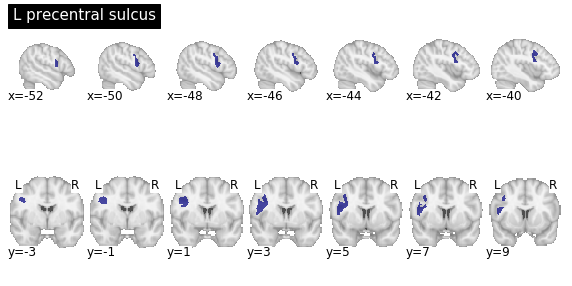

In [9]:
with nl.scope as e:
    e.named_sulcus["L precentral sulcus", e.region] = (
        e.left_frontal_lobe_sulcus(e.region)
        & e.principal_direction(e.region, "SI")
        & ~nl.exists(
            e.other_region,
            e.left_frontal_lobe_sulcus(e.other_region)
            & (e.region != e.other_region)
            & e.anatomical_posterior_of(e.other_region, e.region),
        )
    )

    res = nl.query((e.name, e.region), e.named_sulcus(e.name, e.region))

for name, region in res:
    subplots = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))[1]
    plotting.plot_roi(
        region.spatial_image(), display_mode="x", title=name, axes=subplots[0]
    )
    plotting.plot_roi(
        region.spatial_image(), display_mode="y", axes=subplots[1]
    )

## Example 3: Query the Superior Frontal Sulcus
this query and all defined will not be in the program
after the `with` context finishes. But the results
remain.
In this query we express that the superior frontal sulcus (SFS)
as a sulcus which:

* belongs to the left frontal lobe
* its principal direction is along the anterior-posterior
  axis.
* no other sulcus satisfying the same conditions is
  superior to the SFS.



/home/amachlou/miniconda3/envs/antonia/lib/python3.7/site-packages/numpy/ma/core.py:2786: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


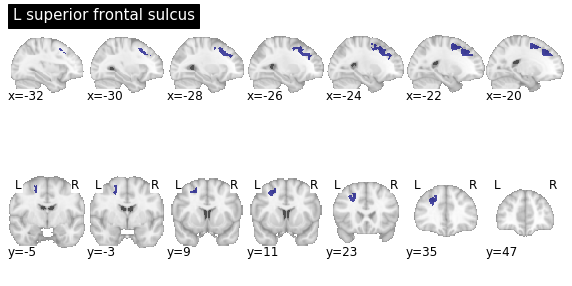

In [10]:
with nl.scope as e:
    e.named_sulcus["L superior frontal sulcus", e.region] = (
        e.left_frontal_lobe_sulcus(e.region)
        & e.principal_direction(e.region, "AP")
        & ~nl.exists(
            e.other_region,
            e.left_frontal_lobe_sulcus(e.other_region)
            & (e.region != e.other_region)
            & e.anatomical_superior_of(e.other_region, e.region),
        )
    )

    res = nl.query((e.name, e.region), e.named_sulcus(e.name, e.region))

for name, region in res:
    subplots = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))[1]
    plotting.plot_roi(
        region.spatial_image(), display_mode="x", title=name, axes=subplots[0]
    )
    plotting.plot_roi(
        region.spatial_image(), display_mode="y", axes=subplots[1]
    )

## Example 3: Query the Inferior Frontal Sulcus
this query and all defined will not be in the program
after the `with` context finishes. But the results
remain.
In this query we express that the inferior frontal sulcus (IFS)
as a sulcus which:

* belongs to the left frontal lobe
* no other sulcus satisfying the same conditions is
  inferior to the IFS.



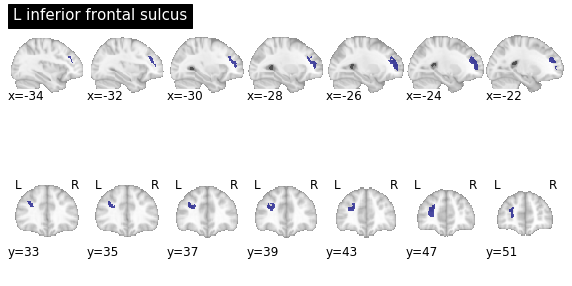

In [11]:
with nl.scope as e:
    e.named_sulcus["L inferior frontal sulcus", e.region] = (
        e.left_frontal_lobe_sulcus(e.region)
        & ~nl.exists(
            e.other_region,
            e.left_frontal_lobe_sulcus(e.other_region)
            & (e.region != e.other_region)
            & e.anatomical_inferior_of(e.other_region, e.region),
        )
    )

    res = nl.query((e.name, e.region), e.named_sulcus(e.name, e.region))

for name, region in res:
    subplots = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))[1]
    plotting.plot_roi(
        region.spatial_image(), display_mode="x", title=name, axes=subplots[0]
    )
    plotting.plot_roi(
        region.spatial_image(), display_mode="y", axes=subplots[1]
    )

# Parietal lobe

## Example 3: Query the Subparietal Sulcus
this query and all defined will not be in the program
after the `with` context finishes. But the results
remain.
In this query we express that the subparietal sulcus (SUBP)
as a sulcus which:

* belongs to the left parietal lobe
* it is dominantly superior of the calcarine sulcus
* no other sulcus satisfying the same conditions is
  inferior to the SUBP.



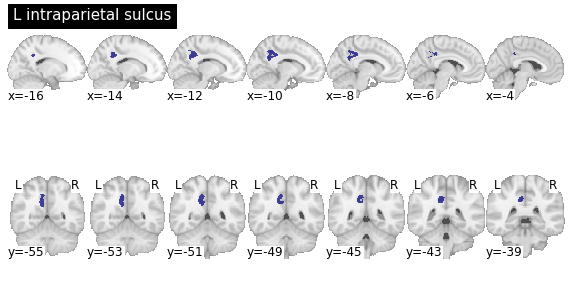

In [18]:
with nl.scope as e:
    e.named_sulcus["L subparietal sulcus", e.region] = (
        e.left_parietal_lobe_sulcus(e.region)
        & e.dominance(e.region, e.destrieux.s['L S_calcarine'], 'superior')
        & ~nl.exists(
            e.other_region,
            e.left_parietal_lobe_sulcus(e.other_region)
            & (e.region != e.other_region)
            & e.anatomical_inferior_of(e.other_region, e.region),
        )
    )

    res = nl.query((e.name, e.region), e.named_sulcus(e.name, e.region))
    
for name, region in res:
    subplots = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))[1]
    plotting.plot_roi(
        region.spatial_image(), display_mode="x", title=name, axes=subplots[0]
    )
    plotting.plot_roi(
        region.spatial_image(), display_mode="y", axes=subplots[1]
    )

## Example 3: Query the Postcentral Sulcus
this query and all defined will not be in the program
after the `with` context finishes. But the results
remain.
In this query we express that the postcentral sulcus (PoCS)
as a sulcus which:

* belongs to the left parietal lobe
* it is dominantly superior of the calcarine sulcus
* no other sulcus satisfying the same conditions is
  anterior to the PoCS.



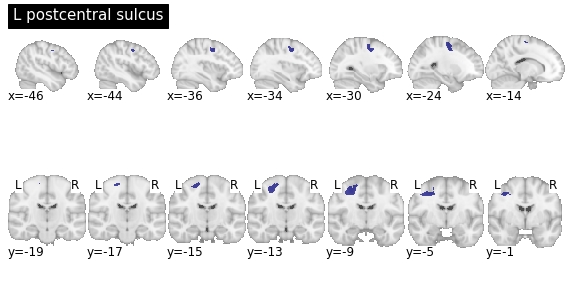

In [13]:
with nl.scope as e:
    e.named_sulcus["L postcentral sulcus", e.region] = (
        e.left_parietal_lobe_sulcus(e.region)
        & ~nl.exists(
            e.other_region,
            e.left_parietal_lobe_sulcus(e.other_region)
            & (e.region != e.other_region)
            & e.anatomical_anterior_of(e.other_region, e.region),
        )
    )

    res = nl.query((e.name, e.region), e.named_sulcus(e.name, e.region))
    
for name, region in res:
    subplots = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))[1]
    plotting.plot_roi(
        region.spatial_image(), display_mode="x", title=name, axes=subplots[0]
    )
    plotting.plot_roi(
        region.spatial_image(), display_mode="y", axes=subplots[1]
    )

# Temporal lobe

## Example 3: Query the Inferior Temporal Sulcus
this query and all defined will not be in the program
after the `with` context finishes. But the results
remain.
In this query we express that the inferior temporal sulcus (ITS)
as a sulcus which:

* belongs to the left temporal lobe
* it is dominantly inferior of the Lateral fissure
* no other sulcus satisfying the same conditions is
  lateral of the ITS.



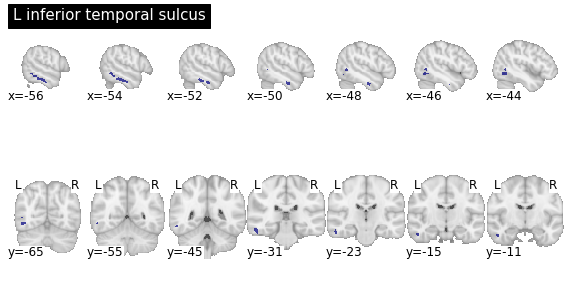

In [14]:
with nl.scope as e:
    e.named_sulcus["L inferior temporal sulcus", e.region] = (
        e.left_temporal_lobe_sulcus(e.region)
        & e.dominance(e.region, e.destrieux.s['L Lat_Fis-post'], 'inferior')
        & ~nl.exists(
            e.other_region,
            e.left_parietal_lobe_sulcus(e.other_region)
            & (e.region != e.other_region)
            & e.left_of(e.other_region, e.region),
        )
    )

    res = nl.query((e.name, e.region), e.named_sulcus(e.name, e.region))
    
for name, region in res:
    subplots = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))[1]
    plotting.plot_roi(
        region.spatial_image(), display_mode="x", title=name, axes=subplots[0]
    )
    plotting.plot_roi(
        region.spatial_image(), display_mode="y", axes=subplots[1]
    )

## Example 3: Query the Collateral Sulcus
this query and all defined will not be in the program
after the `with` context finishes. But the results
remain.
In this query we express that the collateral sulcus (Coll)
as a sulcus which:

* belongs to the left temporal lobe
* it is dominantly inferior of the Parieto occipital sulcus
* no other sulcus satisfying the same conditions is
  inferior of the Coll.



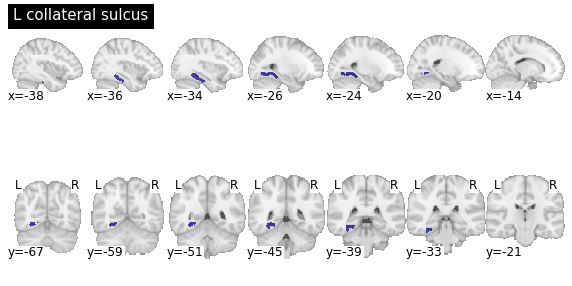

In [15]:
with nl.scope as e:
    e.named_sulcus["L collateral sulcus", e.region] = (
        e.left_temporal_lobe_sulcus(e.region)
        & e.dominance(e.region, e.destrieux.s['L S_parieto_occipital'], 'inferior')
        & ~nl.exists(
            e.other_region,
            e.left_parietal_lobe_sulcus(e.other_region)
            & (e.region != e.other_region)
            & e.anatomical_inferior_of(e.other_region, e.region),
        )
    )

    res = nl.query((e.name, e.region), e.named_sulcus(e.name, e.region))
    
for name, region in res:
    subplots = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))[1]
    plotting.plot_roi(
        region.spatial_image(), display_mode="x", title=name, axes=subplots[0]
    )
    plotting.plot_roi(
        region.spatial_image(), display_mode="y", axes=subplots[1]
    )

# Occipital lobe

## Example 3: Query the Superior Occipital Sulcus
this query and all defined will not be in the program
after the `with` context finishes. But the results
remain.
In this query we express that the superior occipital sulcus (SOS)
as a sulcus which:

* belongs to the left occipital lobe
* it is dominantly posterior of the Lateral fissure
* and is dominantly superior of the calcarine sulcus
* no other sulcus satisfying the same conditions is
  posterior of the SOS.



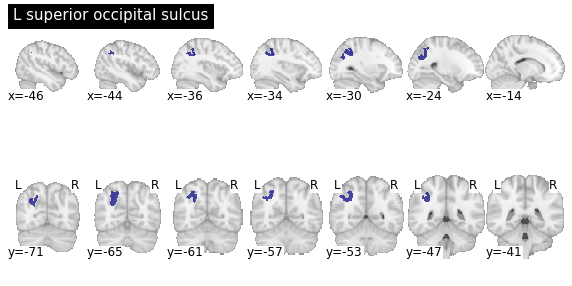

In [16]:
with nl.scope as e:
    e.named_sulcus["L superior occipital sulcus", e.region] = (
        e.left_occipital_lobe_sulcus(e.region)
        & e.dominance(e.region, e.destrieux.s['L Lat_Fis-post'], 'posterior')
        & e.dominance(e.region, e.destrieux.s['L S_calcarine'], 'superior')
        & ~nl.exists(
            e.other_region,
            e.left_parietal_lobe_sulcus(e.other_region)
            & (e.region != e.other_region)
            & e.anatomical_posterior_of(e.other_region, e.region),
        )
    )

    res = nl.query((e.name, e.region), e.named_sulcus(e.name, e.region))
    
for name, region in res:
    subplots = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))[1]
    plotting.plot_roi(
        region.spatial_image(), display_mode="x", title=name, axes=subplots[0]
    )
    plotting.plot_roi(
        region.spatial_image(), display_mode="y", axes=subplots[1]
    )

## Example 3: Query the Intralingual Sulcus
this query and all defined will not be in the program
after the `with` context finishes. But the results
remain.
In this query we express that the intralingual sulcus (ILS)
as a sulcus which:

* belongs to the left occipital lobe
* it is dominantly inferior of the Parieto-Occipital sulcus
* no other sulcus satisfying the same conditions is
  posterior of the ILS.



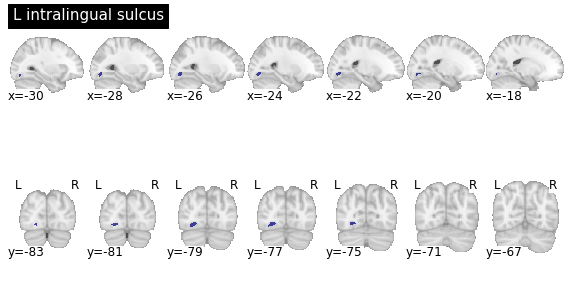

In [17]:
with nl.scope as e:
    e.named_sulcus["L intralingual sulcus", e.region] = (
        e.left_occipital_lobe_sulcus(e.region)
        & e.dominance(e.region, e.destrieux.s['L S_parieto_occipital'], 'inferior')
        & ~nl.exists(
            e.other_region,
            e.left_parietal_lobe_sulcus(e.other_region)
            & (e.region != e.other_region)
            & e.anatomical_posterior_of(e.other_region, e.region),
        )
    )

    res = nl.query((e.name, e.region), e.named_sulcus(e.name, e.region))
    
for name, region in res:
    subplots = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))[1]
    plotting.plot_roi(
        region.spatial_image(), display_mode="x", title=name, axes=subplots[0]
    )
    plotting.plot_roi(
        region.spatial_image(), display_mode="y", axes=subplots[1]
    )